In [3]:
!pip install tensorflow-hub
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

tf.config.list_physical_devices('GPU')

[]

In [7]:
dataset, dataset_info = tfds.load('food101', split='train', with_info=True)
print(dataset_info)

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path='/Users/anastasiia_variichuk/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
       

In [8]:
img_height = 224
img_width = 224
batch_size = 32

# Розрахувати кількість зразків для потягу та тестових наборів
train_size = dataset_info.splits['train'].num_examples
test_size = dataset_info.splits['validation'].num_examples
dataset = dataset.take(test_size)
dataset = dataset.map(
  lambda item: (tf.keras.applications.resnet50.preprocess_input(item['image']), item['label'])
)
dataset = dataset.map(
    lambda img, label: (tf.image.resize(img, (img_height, img_width)), label)
)
dataset = dataset.shuffle(1000).batch(batch_size)

In [9]:
# Розділити набір даних на тренувальний і тестовий набори
train_size = int(test_size*0.8)
test_size = int(test_size*0.2)
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(test_size)

In [10]:
num_classes = dataset_info.features['label'].num_classes
num_classes

101

In [11]:
def eval_model(model, ds, history):
  # Діагностика моделі
  loss = model.evaluate(ds, verbose=0)
  print(f"Sparse categorical crossentropy loss: {loss[1]}")

  # Візуалізуємо результати
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

def eval_models(models, names, histories, ds):
  for history, model, model_name in zip(histories, models, names):
    plt.plot(history.history['accuracy'], label=f'{model_name} accuracy')
    loss = model.evaluate(ds, verbose=0)
    print(f"{model_name}:loss: {loss}")    

  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()


In [12]:
def create_resnet():
  return tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_101/feature_vector/5",
                   trainable = False),
    tf.keras.layers.Dense(num_classes, activation='softmax')
  ])
resnet_adam = create_resnet()
resnet_sgd = create_resnet()

In [13]:
# resnet ADAM
resnet_adam.build([None,224, 224, 3])
resnet_sgd.build([None,224, 224, 3])
resnet_adam.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
resnet_sgd.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [14]:
resnet_adam.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              42605504  
                                                                 
 dense (Dense)               (None, 101)               206949    
                                                                 
Total params: 42,812,453
Trainable params: 206,949
Non-trainable params: 42,605,504
_________________________________________________________________


In [15]:
def create_efficientNet():
  return tf.keras.Sequential([
      hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
                    trainable=False),  # Can be True, see below.
      tf.keras.layers.Dense(num_classes, activation='softmax')
  ])

efficientNet_sgd = create_efficientNet()
efficientNet_adam = create_efficientNet()
efficientNet_sgd.build([None, 224, 224, 3])
efficientNet_adam.build([None, 224, 224, 3])
efficientNet_sgd.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
efficientNet_adam.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
efficientNet_sgd.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              4049564   
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
Total params: 4,178,945
Trainable params: 129,381
Non-trainable params: 4,049,564
_________________________________________________________________


In [16]:
# Створення
model = tf.keras.models.Sequential([
     tf.keras.layers.Conv2D(32, kernel_size = (2,2), activation='relu'),
     tf.keras.layers.MaxPool2D(pool_size = 2, strides=2),

     tf.keras.layers.Conv2D(64, kernel_size = (2,2), activation='relu'),
     tf.keras.layers.MaxPool2D(pool_size = 2, strides=2),

     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(1024, activation='relu'),
     tf.keras.layers.Dense(101, activation='softmax')
 ])


In [17]:
# Компілція
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [18]:
# Навчання
history = model.fit(dataset, epochs=10)

Epoch 1/10


2023-05-05 13:54:06.515798: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


790/790 [==============================] - 1021s 1s/step - loss: 216.4295 - accuracy: 0.0114
Epoch 2/10
790/790 [==============================] - 941s 1s/step - loss: 3.0364 - accuracy: 0.3437
Epoch 3/10
790/790 [==============================] - 976s 1s/step - loss: 0.9643 - accuracy: 0.8080
Epoch 4/10
790/790 [==============================] - 986s 1s/step - loss: 0.3879 - accuracy: 0.9251
Epoch 5/10
790/790 [==============================] - 1009s 1s/step - loss: 0.2283 - accuracy: 0.9564
Epoch 6/10
790/790 [==============================] - 1005s 1s/step - loss: 0.1725 - accuracy: 0.9661
Epoch 7/10
790/790 [==============================] - 1016s 1s/step - loss: 0.1665 - accuracy: 0.9681
Epoch 8/10
790/790 [==============================] - 965s 1s/step - loss: 0.2012 - accuracy: 0.9612
Epoch 9/10
790/790 [==============================] - 966s 1s/step - loss: 0.1971 - accuracy: 0.9624
Epoch 10/10
790/790 [==============================] - 957s 1s/step - loss: 0.2298 - accuracy: 0

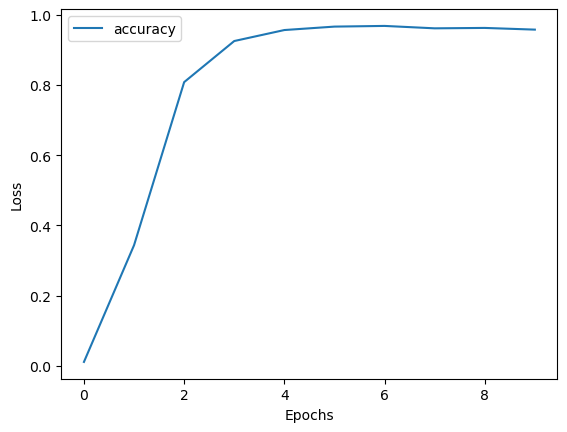

In [20]:
# Візуалізaція результати
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
models = [resnet_adam, resnet_sgd, efficientNet_sgd, efficientNet_adam]
names = ["resnet adam", "resnet sgd", "efficientNet sgd","efficientNet adam"]
histories = []
for model, name  in zip(models[:2], names[:2]):
  print(f"############ starting training {name} ############")
  history = model.fit(train_dataset, epochs=10)
  histories.append(history)

############ starting training resnet adam ############
Epoch 1/10
790/790 [==============================] - 1581s 2s/step - loss: 2056.2227 - accuracy: 0.0117
Epoch 2/10
790/790 [==============================] - 1666s 2s/step - loss: 1936.2006 - accuracy: 0.0145
Epoch 3/10
790/790 [==============================] - 1695s 2s/step - loss: 1860.3517 - accuracy: 0.0162
Epoch 4/10
790/790 [==============================] - 1687s 2s/step - loss: 1784.8264 - accuracy: 0.0179
Epoch 5/10
790/790 [==============================] - 1662s 2s/step - loss: 1776.0616 - accuracy: 0.0192
Epoch 6/10
790/790 [==============================] - 1645s 2s/step - loss: 1776.6870 - accuracy: 0.0190
Epoch 7/10
790/790 [==============================] - 1662s 2s/step - loss: 1786.2633 - accuracy: 0.0202
Epoch 8/10
790/790 [==============================] - 1643s 2s/step - loss: 1730.9376 - accuracy: 0.0200
Epoch 9/10
790/790 [==============================] - 1660s 2s/step - loss: 1762.1479 - accuracy: 0.0202

resnet adam:loss: []
resnet sgd:loss: []


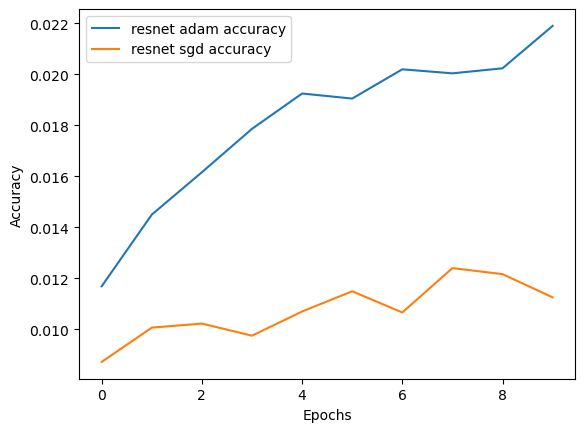

In [23]:
eval_models(models[:2], names[:2], histories[:2], test_dataset)